# A Guide On Solving Non-Convex Consumption-Saving Models

This notebook produces the timing and accuracy results for the benchmark model in [A Guide to Solve Non-Convex Consumption-Saving Models](https://doi.org/10.1007/s10614-020-10045-x).

**Computer used for timings:** Windows 10 computer with 2x Intel(R) Xeon(R) Gold 6254 3.10 GHz CPUs (18 cores, 36 logical processes each) and 768 GB of RAM.

# Setup

In [1]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np

# load the DurableConsumptionModel module
from DurableConsumptionModel import DurableConsumptionModelClass

## Install NLopt

In [2]:
import consav
consav.cpptools.setup_nlopt()

## Choose number of threads in numba

In [3]:
import numba as nb
nb.set_num_threads(8)

# Timing function

In [4]:
def run(name = 'baseline',
        rep = 1, # set to 5 in the paper
        load = False,
        solmethod = 'negm_cpp',
        updpar = {},
        do_simple_wq = False,
        do_print = False):
    
    # a. create model
    par = {'solmethod':solmethod,'do_print':do_print,'do_simple_wq':do_simple_wq,**updpar}
    model = DurableConsumptionModelClass(name=name,load=load,par=par)
    
    # b. run
    cpp_solmethods = ['vfi_cpp','nvfi_cpp','negm_cpp']
    if load == False:
        
        # i. precompile
        if '_cpp' in solmethod:
            model.link_to_cpp(force_compile=False)
        else:
            model.precompile_numba()        
        
        # ii. best of three
        best_time = np.inf
        for it in range(rep):
            
            model.solve()
            total_time = np.sum(model.par.time_w+model.par.time_keep+model.par.time_adj)
            
            if total_time < best_time:
            
                best_time = total_time
                time_w = model.par.time_w.copy()
                time_keep = model.par.time_keep.copy()
                time_adj= model.par.time_adj.copy()
            
            print(f'{it}: total time = {total_time:.2f}')
                
        # iii. collect infomation
        model.simulate(do_euler_error=True,do_utility=True)
        model.par.time_w = time_w.copy()
        model.par.time_keep = time_keep.copy()
        model.par.time_adj= time_adj.copy()
        model.save()    

        if '_cpp' in solmethod:
            model.cpp.delink()
            
    # c. print progress
    print('')    
    model.print_analysis()        
    model.checksum(simple=True)
    print('')
    
    return model

# Settings

In [5]:
load = False
load_negm = load
load_negm_cpp = load
load_negm_cpp_simple = load
load_nvfi = load
load_nvfi_cpp = load
load_nvfi_cpp_simple = load
load_vfi = load
load_vfi_cpp = load

T = 50
models = dict()

# baseline
basename = 'results'
base = dict()
base['Np'] = 150
base['Nn'] = 150
base['Nm'] = 300
base['Nx'] = 300
base['Na'] = 300
base['T'] = T

# Compiling C++

In [6]:
model = DurableConsumptionModelClass(name='')
model.link_to_cpp(do_print=False)
model.cpp.delink()

# Timings

In [7]:
models['negm_cpp'] = run(name=f'{basename}',load=load_negm_cpp,solmethod='negm_cpp',updpar=base)
models['negm_cpp_simple'] = run(name=f'{basename}_simple',load=load_negm_cpp_simple,solmethod='negm_cpp',do_simple_wq=True,updpar=base)
models['negm'] = run(name=f'{basename}',load=load_negm,solmethod='negm',updpar=base)

models['nvfi_cpp'] = run(name=f'{basename}',load=load_nvfi_cpp,solmethod='nvfi_cpp',updpar=base)
models['nvfi_cpp_simple'] = run(name=f'{basename}_simple',load=load_nvfi_cpp_simple,solmethod='nvfi_cpp',do_simple_wq=True,updpar=base)
models['nvfi'] = run(name=f'{basename}',load=load_nvfi,solmethod='nvfi',updpar=base)

models['vfi_cpp'] = run(name=f'{basename}',load=load_vfi_cpp,solmethod='vfi_cpp',updpar=base)

0: total time = 82.05

Name: results (solmethod = negm_cpp)
Grids: (p,n,m,x,a) = (150,150,300,300,300)
Timings:
 total: 82.0
     w: 50.1
  keep: 30.5
   adj: 1.4
Utility: -32.223036
Euler errors:
     total: -4.70 (-5.54,-3.77)
   keepers: -4.67 (-5.56,-3.72)
 adjusters: -4.85 (-5.39,-4.38)
Moments:
 adjuster share: 0.150
         mean c: 0.979
          var c: 0.256
         mean d: 0.555
          var d: 0.107

checksum, inv_v_keep: 0.03966470
checksum, inv_v_adj: 0.03972695

0: total time = 243.60

Name: results_simple (solmethod = negm_cpp)
Grids: (p,n,m,x,a) = (150,150,300,300,300)
Timings:
 total: 243.6
     w: 211.8
  keep: 30.5
   adj: 1.4
Utility: -32.223036
Euler errors:
     total: -4.70 (-5.54,-3.77)
   keepers: -4.67 (-5.56,-3.72)
 adjusters: -4.85 (-5.39,-4.38)
Moments:
 adjuster share: 0.150
         mean c: 0.979
          var c: 0.256
         mean d: 0.555
          var d: 0.107

checksum, inv_v_keep: 0.03966470
checksum, inv_v_adj: 0.03972695

0: total time = 116.10

# Tables

In [8]:
import tabs

In [9]:
main_models = [models['vfi_cpp'],models['nvfi_cpp_simple'],models['negm_cpp_simple'],models['nvfi_cpp'],models['negm_cpp']]
tabs.all(main_models,speedup=True)

In [10]:
main_models = [models['nvfi_cpp'],models['nvfi'],models['negm_cpp'],models['negm']]
tabs.all(main_models,postfix='_python')

# Figures

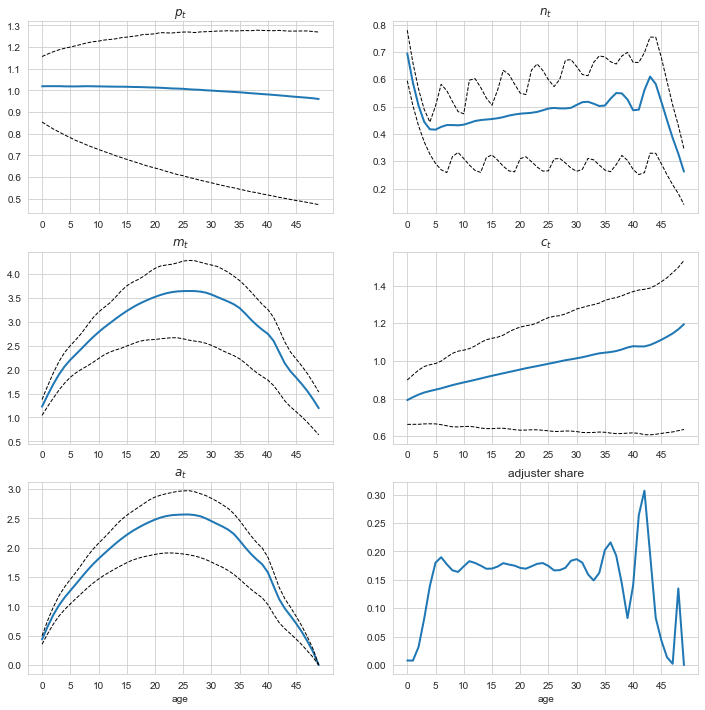

In [11]:
models['negm_cpp'].lifecycle()

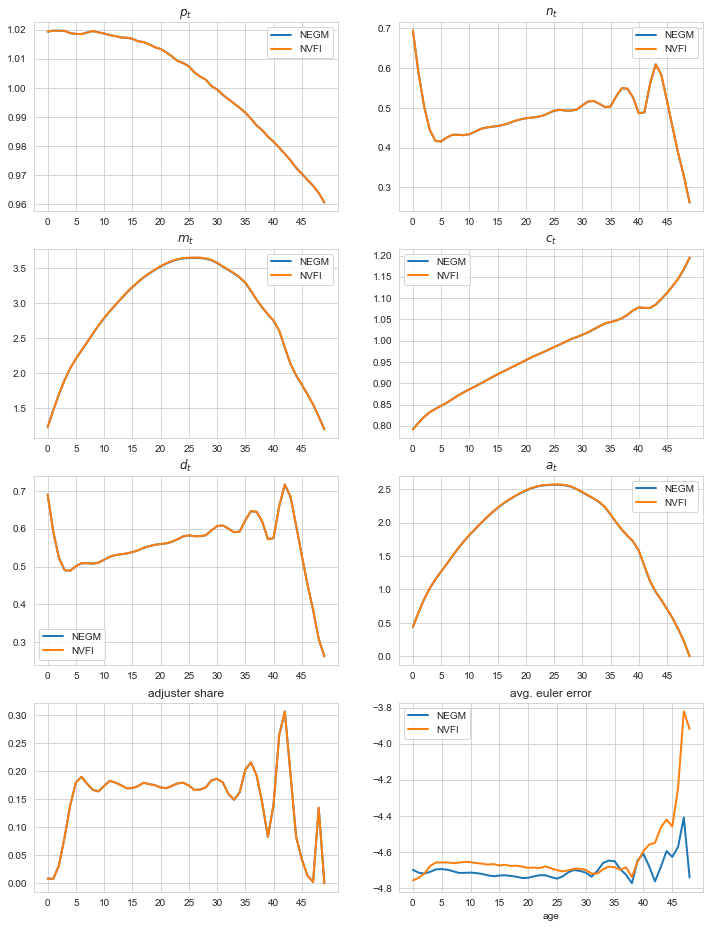

In [12]:
from figs import lifecycle_compare
lifecycle_compare(models['negm_cpp'],'NEGM',models['nvfi_cpp'],'NVFI',do_euler_errors=True)

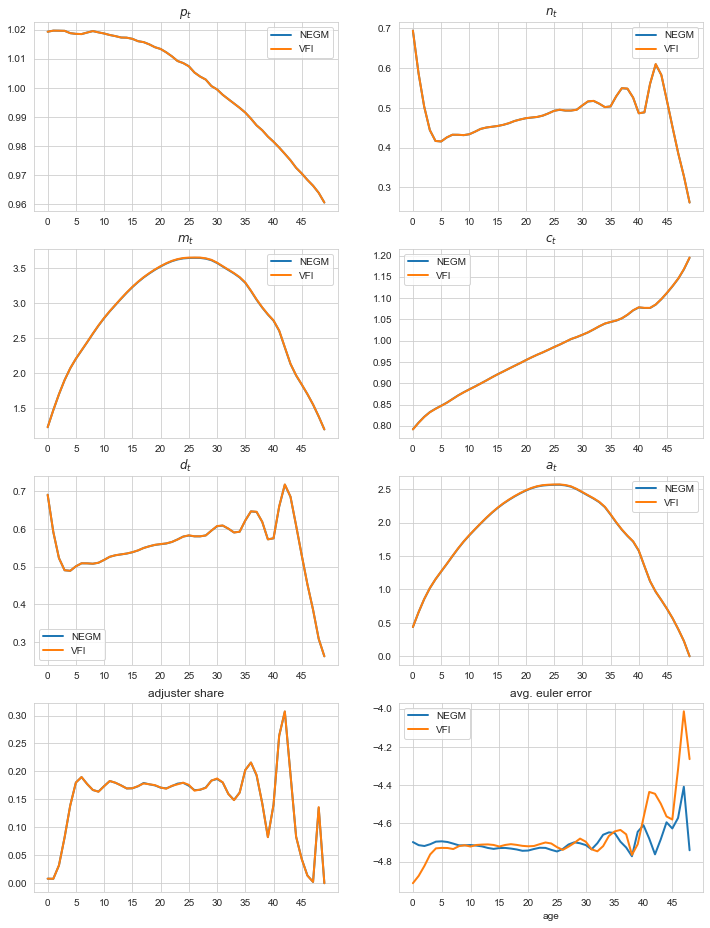

In [13]:
lifecycle_compare(models['negm_cpp'],'NEGM',models['vfi_cpp'],'VFI',do_euler_errors=True)

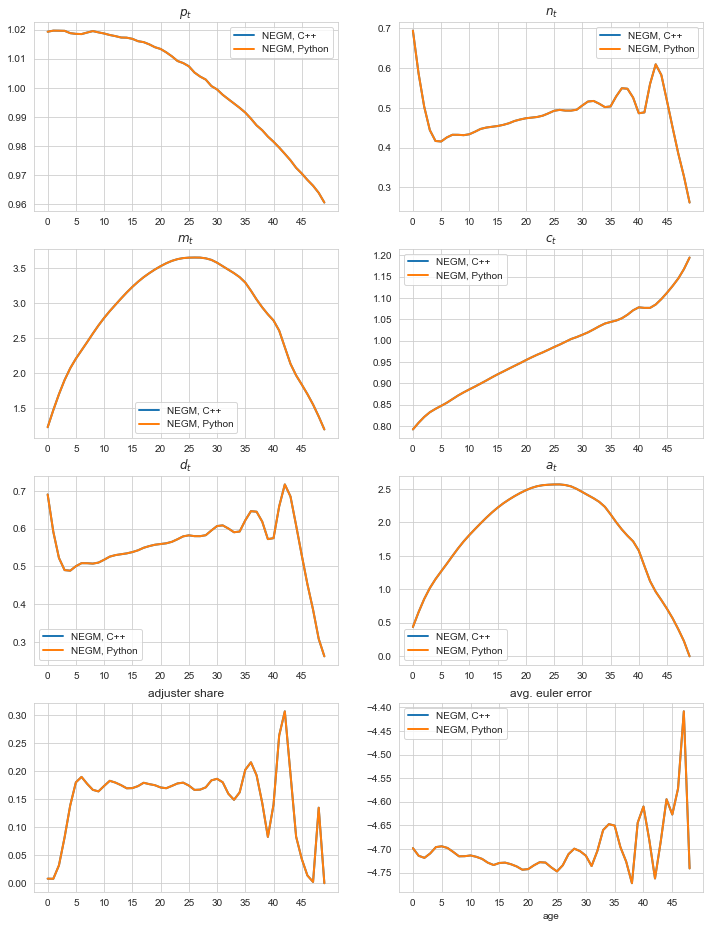

In [14]:
lifecycle_compare(models['negm_cpp'],'NEGM, C++',models['negm'],'NEGM, Python',do_euler_errors=True)